# How to check if a classification model is Overfitted using scikit-learn

One of the hardest problems, when dealing with Machine Learning algorithms, is evaluating whether the trained model performs well with unseen samples. For example, it may happen that a model behaves very well with a given dataset, but it is not able to predict the correct values, when deployed. This discordance between the trained and testing data can be due to different problems. One of the most common problems is overfitting.

A model thats fits the training set well but testing set poorly is said to be overfit to the training set and a model that fits both sets poorly is said to be underfit. Extracted from [this very interesting article](https://towardsdatascience.com/the-relationship-between-bias-variance-overfitting-generalisation-in-machine-learning-models-fb78614a3f1e) by Joe Kadi.

In other words, overfitting means that the Machine Learning model is able to model the training set too well. 

In this tutorial I exploit the Python `scikit-learn` library to check whether a classification model is overfitted. The same procedure can be also exploited for other models, such as regressions. The proposed strategy involves the following steps:
* split the dataset into training and test sets
* train the model with the training set
* test the model on the test set and training set
* calculate the Mean Absolute Error (MAE) for training and test sets
* plot and interpret results

The previous steps must be executed for different training and test sets.

As example dataset, I use the Heart Attack dataset, available in the [Kaggle repository](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

## Load Data
Firstly, I load the dataset as a Dataframe through the Python `pandas` library. The dataset contains 303 records, 13 input features and 1 output class, which can be either 0 or 1.

In [208]:
import pandas as pd

df = pd.read_csv('source/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [209]:
df.shape

(303, 14)

I build the dataset. I define two variables, `X` and `y`, corresponding to the input and output, respectively.

In [210]:
features = []
for column in df.columns:
    if column != 'output':
        features.append(column)
X = df[features]
y = df['output']

## Build and test the model
Usually, `X` and `y` are split into two datasets: training and test. In `scikit-learn` this can be done through the `train_test_split()` function, which returns the training and test data. Then, the model is fitted through the training data and its performance is tested through the test data. However, the described strategy does not permit to verify whether the model is overfitted or not.

For this reason, I do not use the `train_test_split()` function, but the K Folds cross-validation. 

K Folds splits the dataset into k subsets, and trains the model k-times on different training sets and tests the model k-times on different test sets. Each time, the training set is built composing k-1 subsets, while the test set is the remaining subset.

The `scikit-learn` library provides a class for K Folds, called `KFold()`, which receives as input the number `k`. For each pair training, test set, I can build the model and calculate the Mean Absolute Error (MAE) both for training and test sets. In this specific example I exploit the `KNeighborsClassifier()`.

Then I can plot the training and test MAEs and compare them.

I group all the previous operations into a single function, called `test_model()`, which receives as input the model and the `X` and `y` variables.

In [211]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def test_model(model, X, y):
    kf = KFold(n_splits=4)
    mae_train = []
    mae_test = []
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))

    folds = range(1, kf.get_n_splits() + 1)
    plt.plot(folds, mae_train, 'o-', color='green', label='train')
    plt.plot(folds, mae_test, 'o-', color='red', label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of fold')
    plt.ylabel('Mean Absolute Error')
    plt.show()

I plot results. I note that the training MAE is very small (around 0.2) for all k folds. The testing MAE, instead, is very big. It ranges from 0.3 to 0.8. Since the training MAE is small and the testing MAE is big, I can conclude that the model is overfitted.

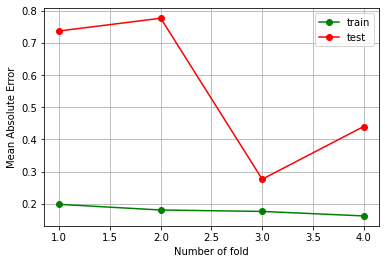

In [212]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
test_model(model, X,y)

## Limit overfitting
Overfitting can be (potentially) limited following two strategies:
* reduce complexity
* tune parameters
* change model.

### Reduce Complexity

I try to improve the model, by scaling all the input features, into a range between 0 and 1. I exploit the `MinMaxScaler()` provided by the `scikit-learn` library.

In [213]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

for column in X.columns:
    feature = np.array(X[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    X[column] = feature_scaled.reshape(1,-1)[0]

<ipython-input-213-63c4d65ac776>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = feature_scaled.reshape(1,-1)[0]
<ipython-input-213-63c4d65ac776>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = feature_scaled.reshape(1,-1)[0]
<ipython-input-213-63c4d65ac776>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

I build a new model and I invoke the `test_model()` function. Now the performance of the model both on training and test sets improves. However, the testing MAE still remains big. Thus, the model is still overfitted.

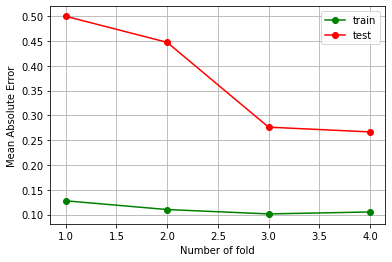

In [214]:
model = KNeighborsClassifier(n_neighbors=2)
test_model(model, X,y)

Another possibility to reduce complexity could be to reduce the number of features. This could be achieved through Principal Component Analysis (PCA). For example, I could reduce the number of input features from 13 to 2. The `scikit-learn` library provides the `PCA()` class for this purpose.

In [215]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca)

I test the model on the new features and I note that the performance of the model improves. Now the testing MAE ranges from 0.20 to 0.45.

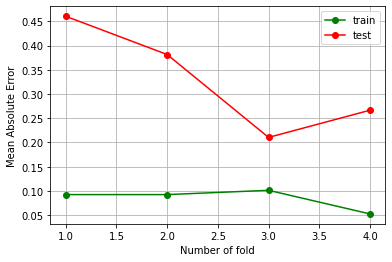

In [216]:
model = KNeighborsClassifier(n_neighbors=2)
test_model(model, X_pca,y)

### Tune parameters

Another possibility could to tune the algorithms parameters. The `scikit-learn` library provides the `GridSearchCV()` class, which permits to search for the best parameters of a specific model. The parameters to be tuned must be passed as a `dict` where for each parameter, the list of values to be analysed must be passed. In addition, `GridSearchCV()` exploits also Cross Validation. The best estimator is available after fitting, in the variable `best_estimator_`.

In [224]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()

param_grid = {
   'n_neighbors': np.arange(1,30),
   'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric' : ['euclidean','manhattan','chebyshev','minkowski']
}

grid = GridSearchCV(model, param_grid = param_grid, cv=4)
grid.fit(X, y)
best_estimator = grid.best_estimator_
best_estimator

KNeighborsClassifier(metric='manhattan', n_neighbors=20)

I test the model. I note that the testing MAE ranges from about 0.25 to 0.45. 

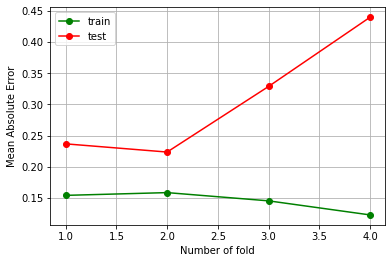

In [225]:
test_model(best_estimator, X,y)

### Change the model
The previous tentatives reduce overfitting. However, the model performance still remain poor. Thus, I try to change model. I try a `GaussianNB()` model. I note that the performance incredibly improves.

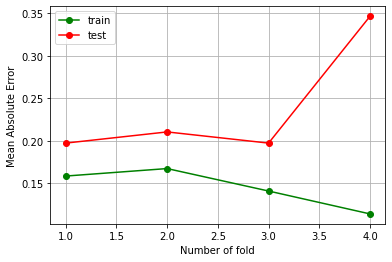

In [227]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
test_model(model, X,y)